# Numerical Exercises 6

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os

csv_path = "./ISING_1D/CSV/"
metr_path = csv_path + "Metr/"
gibbs_path = csv_path + "Gibbs/"
paths = [metr_path, gibbs_path]

plt.rcParams['figure.figsize'] = [8, 5]

points=100
T_th = np.linspace(0.2,2.5,num=points)
T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

In [47]:
J = 1.0
Ns = 50

def U(T):

    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th

    return -J*( th + ch*thN )/( 1 + thN )

def C(T):

    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th

    return ((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

def X(T):

    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns

    return beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

def M(T, h):

    b = 1/T
    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**Ns + l2**Ns

    return (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

In [48]:
def LoadData(filename):
    data = []
    data_final = []

    for path in paths:
        
        suffix = ''
        if path == gibbs_path:
            suffix = '_g'

        data.append(np.flipud(np.loadtxt(path + filename + suffix, delimiter=',')))

    for sample_data in data:

        tmp_data = []
        for row in sample_data:
        
            if row[0] == 20:
    
                tmp_data.append([row[2], row[3]])

        data_final.append(tmp_data)

    return np.asarray(data_final)

A system characterized by constant number of particles $N$, volume $V$ and temperature $T$ (this can be done by putting the system in contact with a reservoir), forms, together with the external reservoir, a microcanonical ensemble ($NVE$). If we assume that the energy of the reservoir is way bigger than the energy of the system (which makes sense since the in order to maintain $T$ constant the reservoir must be a larger system), we can then compute the phase-space density of the system, which will be given by: $$\rho(q,p)=\frac{e^{\frac{-H(q,p)}{k_B T}}}{Z}=\frac{p(q,p)}{Z}$$ Where $Z$ is the partition function and represents the volume in phase-space of the whole canonical ensemble. 

Since, in general, $Z$ is not analytically computable, such systems need to be simulated with a method that does not need to explicitly know the partition function, since, if $Z$ is not needed, we can simply sample $p(q,p)$ knowing only the system's Hamiltonian. In this exercise I will use this two of these methods (Metropolis and Gibbs) to simulate a one-dimensional Ising model.

The Ising model describes a system of spins aligned on an $N$-dimensional lattice, each of which can only interact with its nearest neighbors and can only assume two fixed values, $\pm1$. For such a system, with the additional inclusion of an external magnetic field coupled to each spin, the Hamiltonian and partition function are by: $$H=-J\sum_{\langle ij \rangle}{s_i s_j}-B\sum_{i}s_i, \quad Z = \sum_{s_i} e^{-\beta H}$$ Where $s_i$ is the $i$-th spin (the notation $\langle ij \rangle$ in the sum indicated that $s_i$,$s_j$ are nearest neighbors), $J$ is the interaction strength and $B$ is an external magnetic field. 
Such models admit an analytic solution (i.e. the partition function is analytically known) if the number of dimensions is less then $3$; in particular, for a one-dimensional Ising model the Hamiltonian reduces to (where I used $h$ instead of $B$): $$H=-J\sum_{i=1}^N s_i s_{i+1}-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1})$$
All the main properties of the system can then be computed (analytically or via simulation) from the Hamiltonian, in particular:

1. $U(N,T,h) = \langle H \rangle_{h}$
2. $C(N,T,h) = k_B \beta^2 (\langle H^2 \rangle_{h}-\langle H \rangle_{h}^2)$ 
3. $\chi(N,T,h) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h}$
4. $M(N,T,h)= \langle \sum_{i=1,N}s_i \rangle_{h}$

In this exercise I am going to simulate a one-dimensional Ising model of $50$ spins (with periodic boundary conditions) in the temperature interval $[0.5, 2.0]$ and with $J=1$; I am then going to compare the simulated results with the analytical solutions of the model. As I said before, I used two different sampling methods, Metropolis and Gibbs, which can be schematized as follows:

1. Metropolis
    - Start from the current configuration.
    - Select one random spin $s_i$, flip it and calculate the energy variation $\Delta{E}$ from the previous configuration.
    - Accept the spin flip with probability $A(s_i'|s_i)=min(1, e^{-\beta\Delta{E}})$.
    - Repeat. 

2. Gibbs
    - Start from the current configuration.
    - Select one random spin $s_i$ and set it randomly to a new value (thus generating a new configuration).
    - Compute: $p(s_i\rightarrow-s_i)=\frac{1}{1+e^{-\beta\Delta{E}_{s_i\rightarrow-s_i}}}$ .
    - Accept the generated configuration with probability $p(s_i\rightarrow-s_i)$, otherwise accept the configuration with $s_i$ flipped. 

In each simulation I always used data-blocking with $20$ blocks consisting of $10^5$ steps each.

## 6.1

Before simulating the system, the $50$ spins must be externally initialized. To do this the program allows two options:
1. Randomly place each spin (i.e. treat the system as if $T=+\infty$).
2. Load an pre-computed configuration.

When first started, of course, there is no pre-computed configuration and so only the first option is viable; anyway the generated configuration in general is not an equilibrium state of the system at the given temperature (it is in fact an equilibrium state only if $T=+\infty$) and therefore needs to be equilibrated. To do this I let the system evolve for $1000$ steps (blocks of $1$ step each) and I monitored the magnetization (setting $h = 0.02$) instant values. I chose to use the magnetization since, for lower temperatures, it should clamp to its maximum value; when I notice this phenomenon the system should have reached equilibrium. 

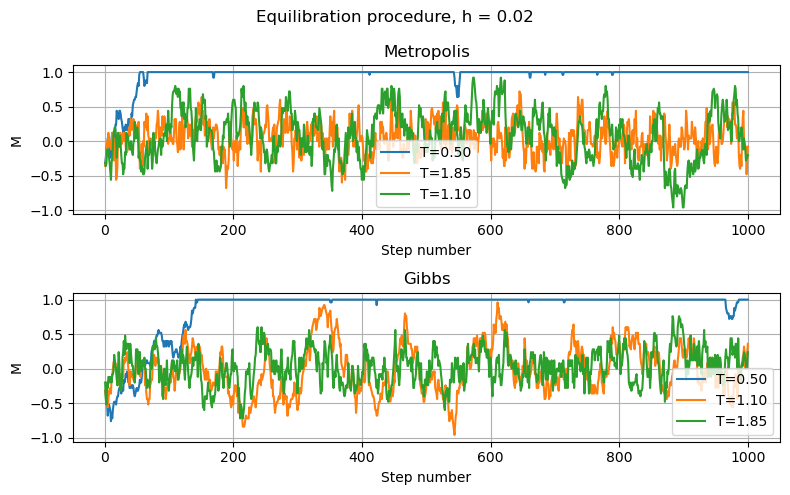

In [65]:
eq_path = csv_path + "Eq/"

eq_path = csv_path + "Eq/"
eq_directories = [os.fsencode(eq_path + "Metr/"), os.fsencode(eq_path + "Gibbs/")]

Titles = ["Metropolis", "Gibbs"]

for idx, directory in enumerate(eq_directories):

    plt.subplot(2, 1, idx + 1)

    for file in os.listdir(directory):

        if "0.02" in os.fsdecode(file):
            
            filename = os.fsdecode(file)
            eq_data = np.loadtxt(os.fsdecode(directory) + filename, delimiter=',')

            Temp = filename[-6:-2].replace("_","0")
            plt.plot(eq_data[:, 0], eq_data[:, 1], label = "T={}".format(Temp))

    plt.xlabel("Step number")
    plt.ylabel("M")
    plt.title(Titles[idx])
    plt.legend()
    plt.grid(True)

plt.gcf().suptitle("Equilibration procedure, h = 0.02")
plt.tight_layout()
plt.show()

It is clear that after around $200$ steps the system reaches equilibrium (this is especially noticeable at low temperature); therefore $1000$ should be enough to guarantee an equilibrate starting point for the actual simulation.
I then proceed to simulate the system loading as input configuration the final configuration of the equilibration process, obtaining the results below.

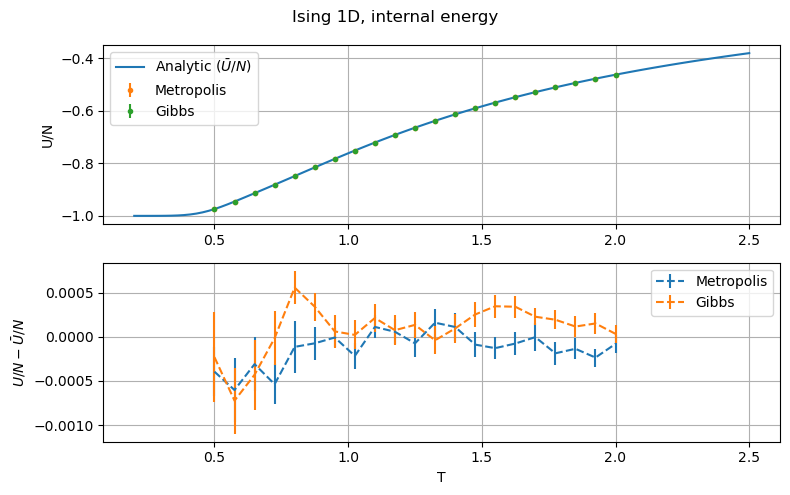

In [50]:
U_data_final = LoadData("output.ene.0")

ax1 = plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(T_th, U(T_th), label = r"Analytic ($\bar{U}/N$)")
plt.ylabel('U/N')
plt.errorbar(T, U_data_final[0][:, 0], yerr =  U_data_final[0][:, 1], fmt='.', label = "Metropolis")
plt.errorbar(T, U_data_final[1][:, 0], yerr =  U_data_final[1][:, 1], fmt='.', label = "Gibbs")
plt.legend()

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, U_data_final[0][:,0] - U(T), yerr =  U_data_final[0][:, 1], linestyle = '--', label = "Metropolis")
plt.errorbar(T, U_data_final[1][:,0] - U(T), yerr =  U_data_final[1][:, 1], linestyle = '--', label = "Gibbs")
plt.ylabel(r"$U/N-\bar{U}/N$")
plt.xlabel("T")
plt.legend()

plt.gcf().suptitle('Ising 1D, internal energy')
plt.tight_layout()
plt.show()

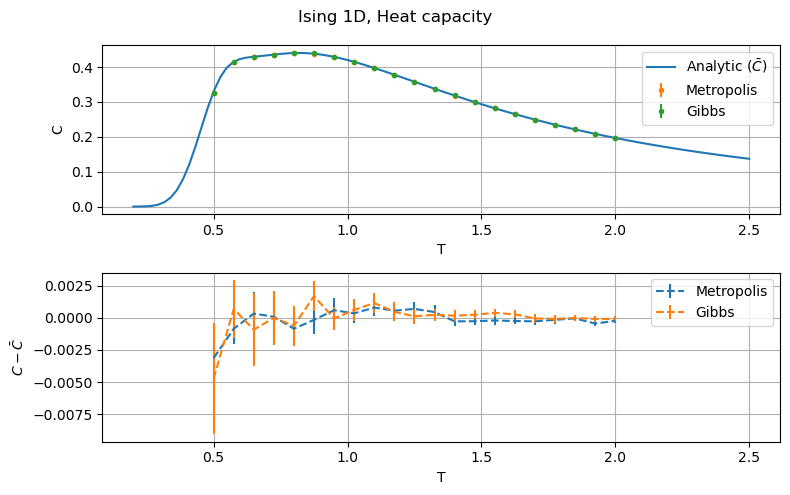

In [51]:
C_data_final = LoadData("output.hec.0")

ax1 = plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(T_th, C(T_th), label = r"Analytic $(\bar{C})$")
plt.xlabel('T')
plt.ylabel('C')
plt.errorbar(T, C_data_final[0][:, 0], yerr =  C_data_final[0][:, 1], fmt = '.', label = "Metropolis")
plt.errorbar(T, C_data_final[1][:, 0], yerr =  C_data_final[1][:, 1], fmt = '.', label = "Gibbs")
plt.legend()

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, C_data_final[0][:,0] - C(T), yerr =  C_data_final[0][:, 1], linestyle = '--', label = "Metropolis")
plt.errorbar(T, C_data_final[1][:,0] - C(T), yerr =  C_data_final[1][:, 1], linestyle = '--', label = "Gibbs")
plt.xlabel("T")
plt.ylabel(r"$C-\bar{C}$")
plt.grid(True)
plt.legend()

plt.gcf().suptitle('Ising 1D, Heat capacity')
plt.tight_layout()
plt.show()

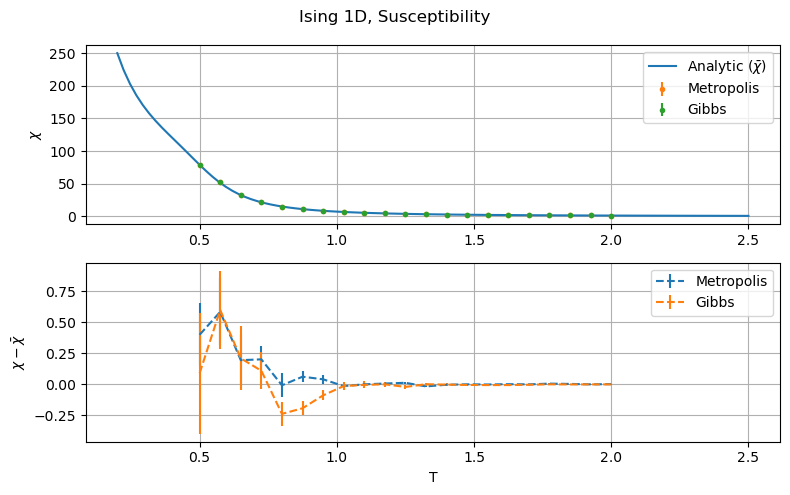

In [52]:
X_data_final = LoadData("output.chi.0")

ax1 = plt.subplot(2, 1, 1)
plt.plot(T_th, X(T_th), label = r"Analytic ($\bar{\chi}$)")
plt.ylabel('$\chi$')
plt.errorbar(T, X_data_final[0][:, 0], yerr =  X_data_final[0][:, 1], fmt='.', label = "Metropolis")
plt.errorbar(T, X_data_final[1][:, 0], yerr =  X_data_final[1][:, 1], fmt='.', label = "Gibbs")
plt.legend()
plt.grid(True)

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, X_data_final[0][:,0] - X(T), yerr =  X_data_final[0][:, 1], linestyle = '--', label = "Metropolis")
plt.errorbar(T, X_data_final[1][:,0] - X(T), yerr =  X_data_final[1][:, 1], linestyle = '--', label = "Gibbs")
plt.xlabel('T')
plt.ylabel(r'$\chi-\bar{\chi}$')
plt.legend()
plt.grid(True)

plt.gcf().suptitle('Ising 1D, Susceptibility')
plt.tight_layout()
plt.show()

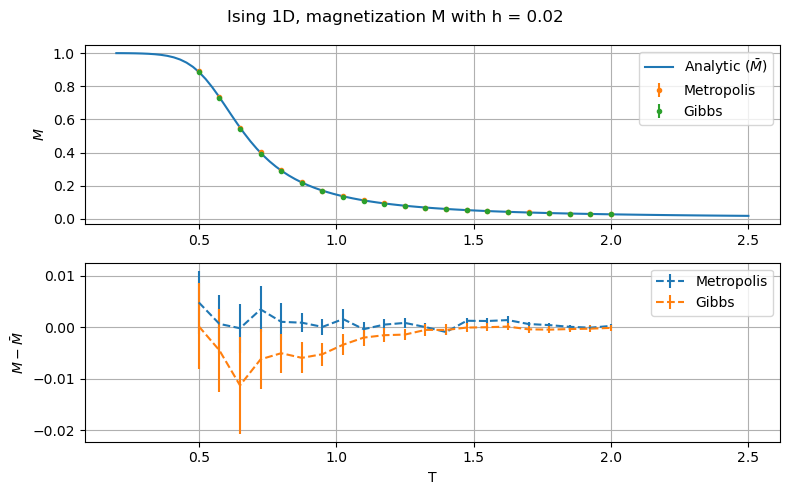

In [53]:
M_data_final = LoadData("output.mag.0.02")

h=0.02 #external field

ax1 = plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(T_th, M(T_th, h), label = r"Analytic ($\bar{M}$)")
plt.ylabel('$M$')
plt.errorbar(T, M_data_final[0][:, 0], yerr =  M_data_final[0][:, 1], fmt='.', label = "Metropolis")
plt.errorbar(T, M_data_final[1][:, 0], yerr =  M_data_final[1][:, 1], fmt='.', label = "Gibbs")
plt.legend()

ax2 = plt.subplot(2, 1, 2, sharex = ax1)
plt.grid(True)
plt.errorbar(T, M_data_final[0][:,0] - M(T, h), yerr =  M_data_final[0][:, 1], linestyle = '--', label = "Metropolis")
plt.errorbar(T, M_data_final[1][:,0] - M(T, h), yerr =  M_data_final[1][:, 1], linestyle = '--', label = "Gibbs")
plt.xlabel('T')
plt.ylabel(r"$M-\bar{M}$")
plt.legend()
plt.grid(True)

plt.gcf().suptitle('Ising 1D, magnetization M with h = 0.02')
plt.tight_layout()
plt.show()

Looking at the first graph of each of these figures it is clear (at least graphically) that the simulation data obtained with both methods agrees with the analytic solution of the model. The second graph, in which the difference between the simulation data and the exact value from analytical model is reported we can confirm quantitatively the last statement, at least within two standard deviation. It is also important to note that the compatibility between theory and simulation degrades in the transition region $[0.5,1.0]$ where a phase-transition takes place; anyway, this fact is compensated by an higher statistical error and thus the compatibility is preserved. This last sentence is true when using $10^5$ steps per block but, when I tried to lower this number to $10^4$ s/b, the discrepancy started to be noticeable and exceed two standard deviations.